# DCGAN with Labeled Faces in the Wild Dataset

- torch-ganの`create_datasets.py`で`lfw.hdf5`を作成
- http://vis-www.cs.umass.edu/lfw/
- http://torch.ch/blog/2015/11/13/gan.html
- https://github.com/skaae/torch-gan

In [93]:
%matplotlib inline
import matplotlib as mpl
mpl.use('Agg')

import os
import h5py
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Flatten, Dropout, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

np.random.seed(7)

/Users/koichiro.mori/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## データセットをロード

In [89]:
f = h5py.File('./data/lfw.hdf5', 'r')
print(list(f.keys()))
lfw = f['lfw'][:]
print(lfw.shape)
X_train = lfw.transpose((0, 2, 3, 1))
print(X_train.shape)

['lfw']
(13233, 3, 64, 64)
(13233, 64, 64, 3)


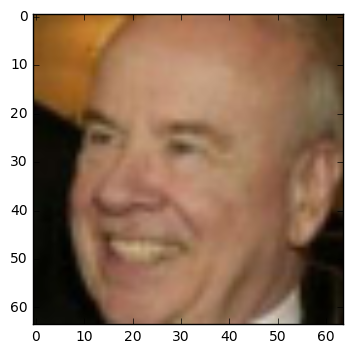

In [90]:
plt.imshow(X_train[1])

## DCGANモデルを作成

In [74]:
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=512, units=8 * 8 * 128))
    model.add(Reshape((8, 8, 128), input_shape=(8 * 8 * 128, )))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(3, (3, 3), padding='same'))
    return model

def discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(96, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [109]:
def plot_images(images, fname=None, figsize=(12, 12), rows=4):
    assert images.shape[0] == 16
    f = plt.figure(figsize=figsize)
    for i in range(len(images)):
        sp = f.add_subplot(rows, len(images) // rows, i + 1)
        sp.axis('off')
        plt.imshow(images[i])
    if fname is not None:
        plt.savefig(fname)

In [76]:
BATCH_SIZE = 128
NUM_EPOCH = 100
GENERATED_IMAGE_PATH = 'generated_images/'
MODEL_PATH = 'models/'

if not os.path.exists(GENERATED_IMAGE_PATH):
    os.mkdir(GENERATED_IMAGE_PATH)

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# discriminatorのみのモデル構築
discriminator = discriminator_model()
d_opt = Adam(lr=1e-5, beta_1=0.1)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)
discriminator.summary()

# generator + discriminatorのモデル構築
# discriminatorの重みは固定（固定されるのはdcganの中のdiscriminatorのみ）
# trainableを反映させるにはcompile()が必要
# summary()表示するとわかる
discriminator.trainable = False
generator = generator_model()
# generatorが生成した画像をdiscriminatorが予測
dcgan = Sequential([generator, discriminator])
g_opt = Adam(lr=2e-4, beta_1=0.5)
dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)
dcgan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
activation_43 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
activation_44 (Activation)   (None, 16, 16, 64)        0         
__________

## 訓練

In [112]:
num_batches = int(X_train.shape[0] / BATCH_SIZE)
print('Number of batches:', num_batches)

d_loss_history = []
g_loss_history = []

for epoch in range(NUM_EPOCH):
    for index in range(num_batches):
        # Generatorへの入力となるノイズベクトルをバッチサイズ分作成
        noise = np.array([np.random.normal(0, 1, 512) for _ in range(BATCH_SIZE)])
        
        # 本物の画像（訓練データ）
        image_batch = X_train[index * BATCH_SIZE:(index + 1) * BATCH_SIZE]
        
        # 生成画像
        generated_images = generator.predict(noise, verbose=0)
        
        # discriminatorを更新
        X = np.concatenate((image_batch, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        d_loss = discriminator.train_on_batch(X, y)
        d_loss_history.append(d_loss)

        # generatorを更新
        noise = np.array([np.random.normal(0, 1, 512) for _ in range(BATCH_SIZE)])
        g_loss = dcgan.train_on_batch(noise, [1] * BATCH_SIZE)
        g_loss_history.append(g_loss)

        print('epoch: %d, batch: %d, g_loss: %f, d_loss: %f' % (epoch, index, g_loss, d_loss))

    # 各エポックで生成画像を出力
    generated_images *= 255.0
    generated_images = generated_images.astype(np.uint8)
    image = plot_images(generated_images[:16], GENERATED_IMAGE_PATH + 'epoch-%04d.png' % (epoch))
    
    # モデルを保存
    generator.save('%s/generator-%03d-%.2f.h5' % (MODEL_PATH, epoch, g_loss))
    discriminator.save('%s/discriminator-%03d-%.2f.h5' % (MODEL_PATH, epoch, d_loss))

Number of batches: 103


KeyboardInterrupt: 

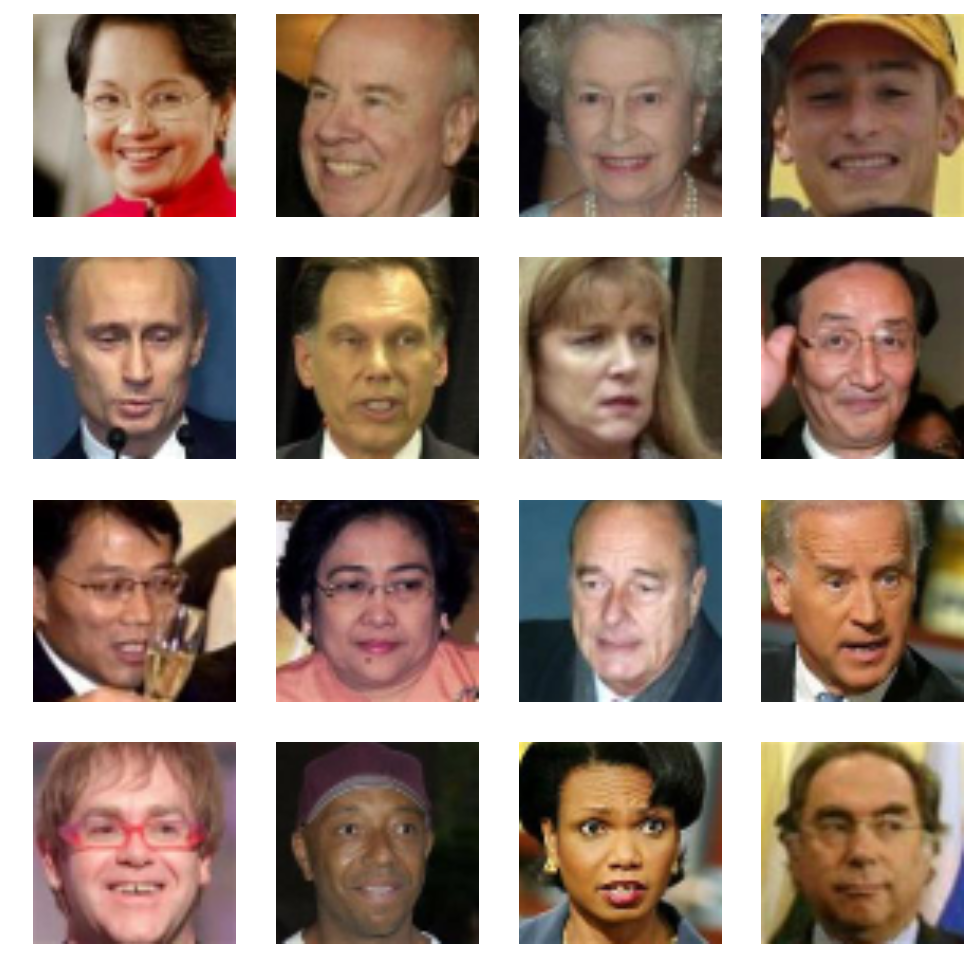

In [114]:
plot_images((X_train[:16] * 255.0).astype(np.uint8), 'test.png')

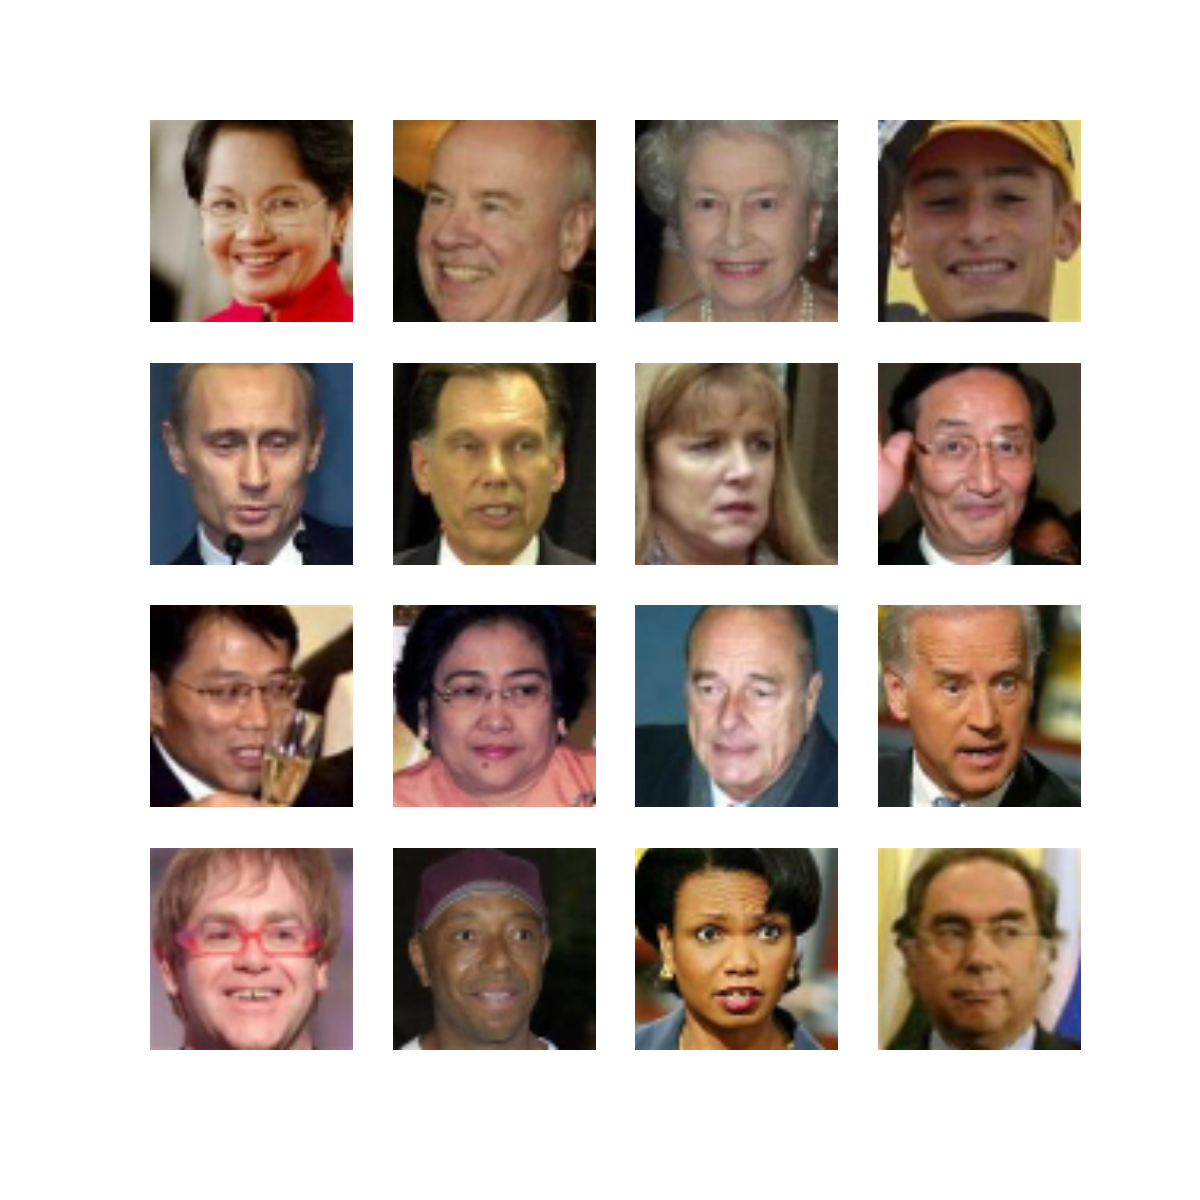

In [115]:
from IPython.display import Image
Image('test.png')